## Fine Tuning Transformers for Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Sep 21 14:33:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 40%   44C    P8     1W /  38W |     62MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 37%   

Set up the cuda devices. Be good citizens of the machine.

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [4]:
import torch 

def get_available_devices():
    """Get IDs of all available GPUs.

    Returns:
        device (torch.device): Main device (GPU 0 or CPU).
        gpu_ids (list): List of IDs of all GPUs that are available.
        device_props (list): List of gpu _CudaDeviceProperties dictionaries generally ordered fastest to slowest
    """
    gpu_ids = []
    device_props = []
    if torch.cuda.is_available():
        gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
        for i in range(torch.cuda.device_count()):
            device_props.append(torch.cuda.get_device_properties(i))
        device = torch.device(f'cuda:{gpu_ids[0]}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    return device, gpu_ids, device_props 

device, gpu_ids, device_props = get_available_devices()
print(device, gpu_ids, device_props)

cuda:0 [0, 1] [_CudaDeviceProperties(name='NVIDIA TITAN V', major=7, minor=0, total_memory=12066MB, multi_processor_count=80), _CudaDeviceProperties(name='NVIDIA TITAN V', major=7, minor=0, total_memory=12066MB, multi_processor_count=80)]


Look at the datasets available, but then load the emotions dataset

In [5]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 10035 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [6]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/home/jupyter-qsnell/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

### Now let's get the transformer going

In [7]:
model_ckpt = "distilbert-base-uncased"

Set up the tokenizer for our model and encode all the input

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [10]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/jupyter-qsnell/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-8d0cd491f68f07f1.arrow
Loading cached processed dataset at /home/jupyter-qsnell/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-c8e4011086d291d4.arrow
Loading cached processed dataset at /home/jupyter-qsnell/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-22e2c43955d09555.arrow


In [11]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Load the model with a preset classification head

In [12]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [13]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

#### Training functions

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [15]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [16]:
from transformers import Trainer, TrainingArguments

def train_model(model, model_name, epochs):
    batch_size = 8
    logging_steps = len(emotions_encoded["train"]) // batch_size
    training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  report_to=None,
                                  log_level="error")
    trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
    trainer.train();
    return trainer

2022-09-21 14:33:48.133403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 14:33:48.336784: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 14:33:49.244321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-21 14:33:49.244431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Now train the model and see how well it did

In [17]:
trainer = train_model(model, f"{model_ckpt}-finetuned-emotion", 2)

/opt/tljh/user/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qsnell. Use `wandb login --relogin` to force relogin


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.204695,0.925500,0.925459
2,0.321900,0.165217,0.932500,0.932659


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; wi

In [18]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.165216863155365,
 'test_accuracy': 0.9325,
 'test_f1': 0.9326589350810809,
 'test_runtime': 4.4242,
 'test_samples_per_second': 452.055,
 'test_steps_per_second': 28.253}

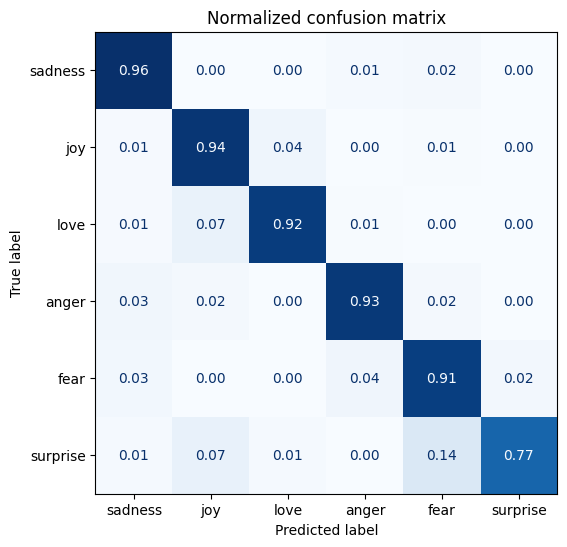

In [19]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions_encoded["validation"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)

#### Let's try putting on a different classifier head and see how it does

In [20]:
qmodel = model

In [21]:
qmodel.pre_classifier.out_features

768

In [22]:
import torch
import torch.nn as nn

model_dropout = 0.25
classifier_dropout = 0.3
base_model_output_size = qmodel.pre_classifier.out_features

qmodel.num_labels = num_labels
qmodel.classifier = nn.Sequential(
            nn.Dropout(model_dropout),
            #nn.Conv1d(base_model_output_size, base_model_output_size//16, 3, stride=2),
            nn.Linear(base_model_output_size, base_model_output_size//8),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(base_model_output_size//8, base_model_output_size//16),
            nn.ReLU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(base_model_output_size//16, num_labels),
        )

In [23]:
print(qmodel)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Train the new model and see how it does. Add more epochs because we have our dropout rates high. Hopefully it helps it generalize a bit better.

In [24]:
trainer = train_model(model, f"{model_ckpt}-finetuned-emotion-3layer-Classification", 3)

/opt/tljh/user/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.252015,0.934000,0.934216
2,0.399200,0.216090,0.934500,0.934635
3,0.399200,0.221520,0.937000,0.936978


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; wi

In [25]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.22152025997638702,
 'test_accuracy': 0.937,
 'test_f1': 0.9369777737619062,
 'test_runtime': 4.5322,
 'test_samples_per_second': 441.286,
 'test_steps_per_second': 27.58}

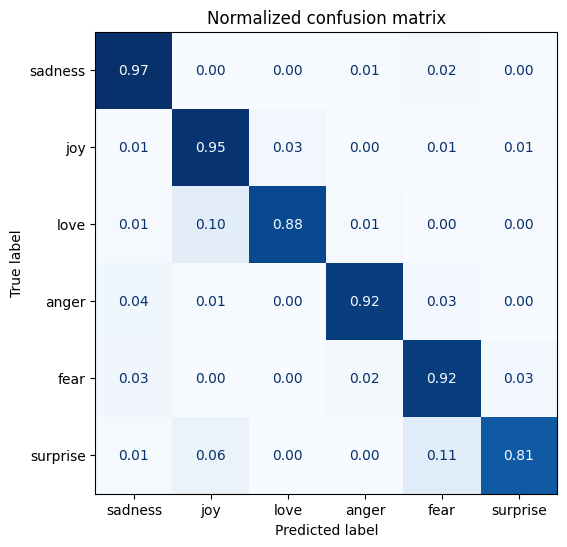

In [26]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions_encoded["validation"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)